## Mask Reading

In this notebook we read our own annotations, overlay them in the images and then find the impacted CCDs.
This is crucial if we want to estimate any detection metric, using our annotations as the "true" masks.

**Import Python packages**

In [1]:
import numpy as np 
import scipy as scipy 
import os
import json
from PIL import Image
import skimage.draw
import pandas as pd
import numpy.ma as ma
import imageio
# ===================================
# ===================================

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

Import `json` annotations file.

In [2]:
annotations_or = json.load(open("common_core_Dimitrios.json"))
annotations_file = list(annotations_or['_via_img_metadata'].values())  # don't need the dict keys

In [3]:
print(np.shape(annotations_file))

(50,)


Now work for one image only, but in a way that can be generalized to more images.

In [21]:
i = 35
# Let's print the annotations file to see how it looks like
img_annotations = annotations_file[i]
print(img_annotations)

{'filename': 'Ghost_img_D00409444.jpg', 'size': 39984, 'regions': [{'shape_attributes': {'name': 'ellipse', 'cx': 295, 'cy': 245, 'rx': 27, 'ry': 38.626, 'theta': -2.771}, 'region_attributes': {'Type': 'Bright'}}, {'shape_attributes': {'name': 'circle', 'cx': 41, 'cy': 125, 'r': 18.248}, 'region_attributes': {'Type': 'Bright'}}, {'shape_attributes': {'name': 'polyline', 'all_points_x': [20, 67, 75, 64, 48, 23, 19, 21], 'all_points_y': [105, 108, 132, 151, 162, 152, 148, 107]}, 'region_attributes': {'Type': 'Bright'}}, {'shape_attributes': {'name': 'circle', 'cx': 92, 'cy': 148, 'r': 16}, 'region_attributes': {'Type': 'Bright'}}, {'shape_attributes': {'name': 'circle', 'cx': 131, 'cy': 171, 'r': 74}, 'region_attributes': {'Type': 'Faint'}}, {'shape_attributes': {'name': 'circle', 'cx': 170, 'cy': 186, 'r': 121.066}, 'region_attributes': {'Type': 'Faint'}}], 'file_attributes': {}}


Get filename and plot the relevant image

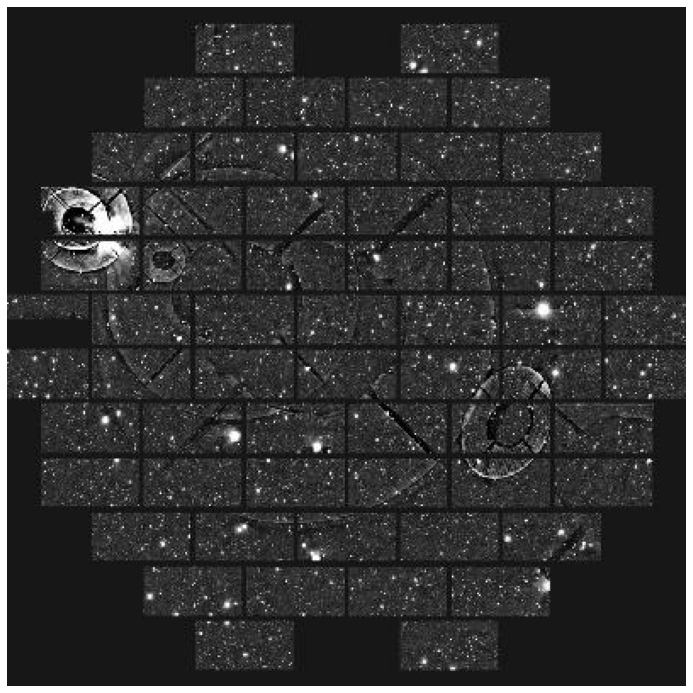

In [23]:
filename = img_annotations['filename']

# Get image
image = Image.open(filename)

# Plot image
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(image,cmap='gray')

plt.tight_layout()
plt.axis('off')
plt.savefig('Bright_faint_image.pdf',dpi=100)


plt.show()

Now get the masks

In [7]:
regions = img_annotations['regions']
num_ghosts = len(regions) # Number of different Ghosts/Masks


print(len(regions))
regions = regions[0]
print(regions)

2
{'shape_attributes': {'name': 'polyline', 'all_points_x': [286, 320, 319, 336, 324, 297, 276, 263, 254, 225, 261, 303, 216, 197, 285], 'all_points_y': [40, 41, 71, 72, 104, 166, 182, 189, 198, 205, 134, 63, 150, 123, 40]}, 'region_attributes': {'Type': 'Rays'}}


## Generalize

Now generalize the above, in order to be able to work for images with arbitrary number of ghosts.
Write code that:

- Finds number of Ghosts in an image, `n_G`.
- Saves the masks in a form `X_{mask}[400,400,n_G]`.
- Make plot where each ghost category (Rays, Bright, Faint) is plotted with a different color.
- Find affected CCDs and plot them. 
- As a next step: Assign each affected CCD to one ghost category. If there are more than one ghosts in that CCD choose Rays>bright>Faint (or the category with the most pixels).

In [24]:
i = 35
# Get annotations for the i-th image
img_annotations = annotations_file[i]

Get the file name and the image, for future reference

In [25]:
# Get filename
filename = img_annotations['filename']
# Get image 
image = Image.open(filename)

Now work for the masks

In [26]:
regions = img_annotations['regions']

# Now get the number of ghosts
n_ghosts = len(regions)

print(n_ghosts)

6


In [27]:
Types = []
X_mask = np.zeros([400,400,n_ghosts]) #Array that contains the ghost masks

for j in range(n_ghosts):
    regions_loc = regions[j] #j-th
    
    # ==============================
    # First get ghost types
    Type_loc = regions_loc['region_attributes']['Type']
    Types.append(Type_loc)
    
    # ==============================
    # Get shape attributes
    shape_attrs = regions_loc['shape_attributes']
    
    # Get the name of the shape attribute
    name = shape_attrs['name']
    
    if (name=='polyline'):
        rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
        a = (rr<400)&(cc<400)
        X_mask[rr[a], cc[a], j] = 1
    elif (name=='polygon'):
        rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
        a = (rr<400)&(cc<400)
        X_mask[rr[a], cc[a], j] = 1
    elif (name=='rect'):
        rr, cc = skimage.draw.rectangle(start=(shape_attrs['y'], shape_attrs['x']),
                                        extent=(shape_attrs['height'],shape_attrs['width']))
        a = (rr<400)&(cc<400)
        X_mask[rr[a], cc[a], j] = 1
    elif (name=='circle'):
        rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])
        a = (rr<400)&(cc<400)
        X_mask[rr[a], cc[a], j] = 1
    else: #This is the case when you have an ellipse 
        rr, cc = skimage.draw.ellipse(shape_attrs['cy'],shape_attrs['cx'],
                                      shape_attrs['ry'],shape_attrs['rx'],
                                      shape=None,rotation=-shape_attrs['theta'])
        a = (rr<400)&(cc<400)
        X_mask[rr[a], cc[a], j] = 1
# ======================================================
X_mask = ma.masked_where(X_mask<1, X_mask)

<ipython-input-27-44e52d3207ac>:33: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])


**Make plot**

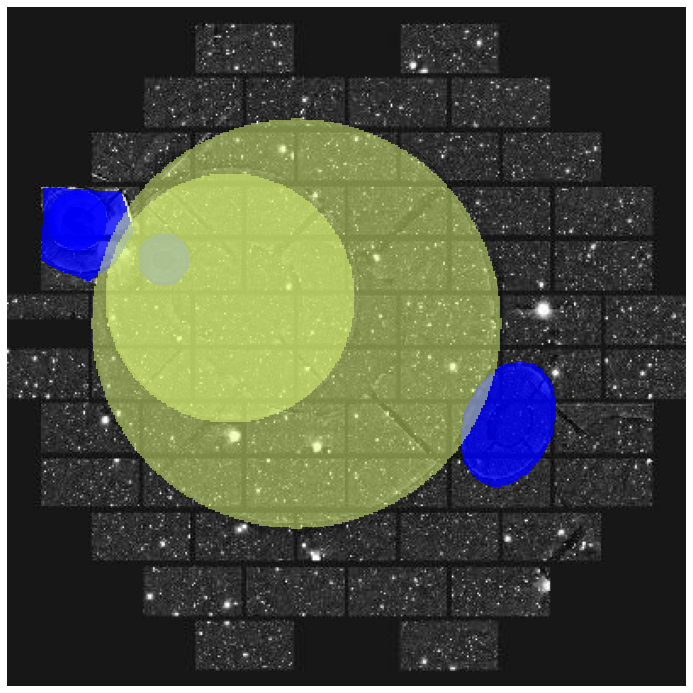

In [30]:
plot_pretty() 
plt.figure(figsize=(10, 10))

plt.imshow(image,cmap='gray')


for i in range(n_ghosts):
    Type_i = Types[i]
    if (Type_i=='Rays'):
        plt.imshow(X_mask[:,:,i],cmap='autumn',alpha=0.85)
    elif(Type_i=='Faint'):
        plt.imshow(X_mask[:,:,i],cmap='Wistia',alpha=0.5)
    else:
        plt.imshow(X_mask[:,:,i],cmap='winter',alpha=0.8)

plt.tight_layout()
plt.axis('off')
plt.savefig('Bright_faint_annot.pdf',dpi=100)
plt.show()

### Affected CCDs 

Now, for the same image, find the affected CCDs and mask them

In [204]:
from run import fov_geometry
ccds = np.asarray(fov_geometry(release='y1a1',size=[400,400]))

print(np.shape(ccds))


name = ccds[:,0]
x_min = ccds[:,1]
y_min = ccds[:,2]
x_max = ccds[:,3]
y_max = ccds[:,4]

x_min_pr = x_min + (x_min-200)*38.5*0.0025
x_max_pr = x_max + (x_max-200)*38.5*0.0025

(62, 5)


In [19]:
X_mask_summed = np.sum(X_mask,axis=2)

In [20]:
# Now find the affected CCDs
CCDs_affected = []

for i in range(62):
    CCD_loc = i
    loc_mask = X_mask_summed[int(y_min[i]):int(y_max[i])+1,max(0,int(x_min_pr[i])):int(x_max_pr[i])+1]
    # In the above i use max(0,..) because some minima were negative
    #print(np.sum(loc_mask))
    if (loc_mask.any()==True):    
        CCDs_affected.append(i)

In [21]:
#print(min(x_min_pr))
#print(max(1,lol))

In [22]:
import numpy.ma as ma
X_mask = np.zeros([400,400])

for i in range(len(CCDs_affected)):
    CCD_loc = CCDs_affected[i]
    X_mask[int(y_min[CCD_loc]):int(y_max[CCD_loc])+1,max(0,int(x_min_pr[CCD_loc])):int(x_max_pr[CCD_loc])+1] =1 

In [23]:
mask_CCD = ma.masked_where(X_mask<1, X_mask)

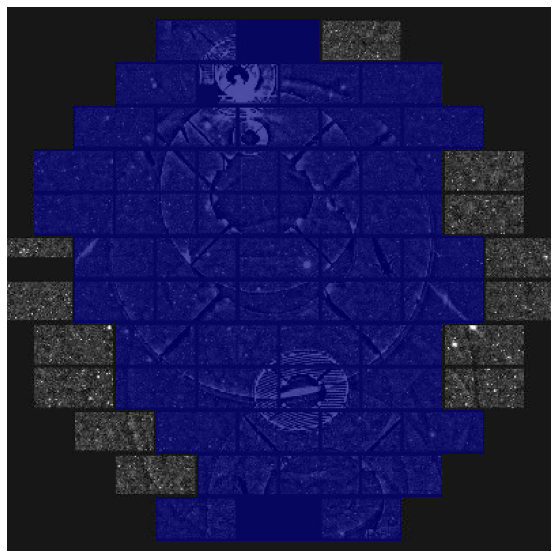

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(image,cmap='gray')
plt.imshow(mask_CCD,cmap='jet',alpha=0.7)

#plt.scatter(x_min_pr[60],y_max[60],c='y')
plt.axis('off')
plt.show()

In [25]:
33*60*0.05

99.0

**Now require that a CCD is at least $5\%$ affected**

At least 100 pixes

In [26]:
# Now find the affected CCDs
CCDs_aff_new = []

for i in range(62):
    CCD_loc = i
    loc_mask = X_mask_summed[int(y_min[i]):int(y_max[i])+1,max(0,int(x_min_pr[i])):int(x_max_pr[i])+1]
    
    if (np.sum(loc_mask)>100):    
        CCDs_aff_new.append(i)

In [27]:
X_mask = np.zeros([400,400])

for i in range(len(CCDs_aff_new)):
    CCD_loc = CCDs_aff_new[i]
    X_mask[int(y_min[CCD_loc]):int(y_max[CCD_loc])+1,max(0,int(x_min_pr[CCD_loc])):int(x_max_pr[CCD_loc])+1] =1 

In [28]:
mask_CCD = ma.masked_where(X_mask<1, X_mask)

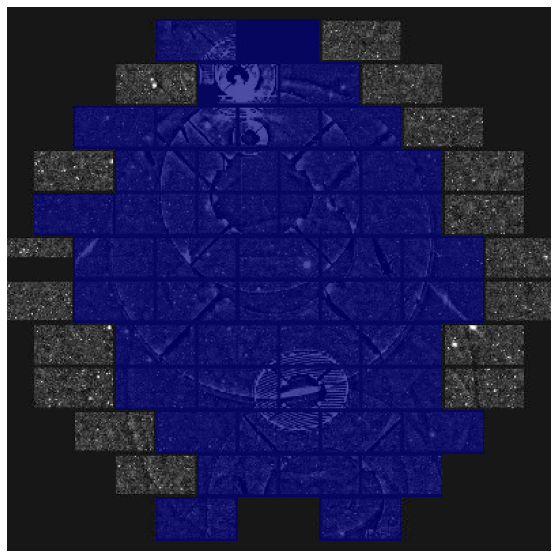

In [29]:
plt.figure(figsize=(10, 10))
plt.imshow(image,cmap='gray')
plt.imshow(mask_CCD,cmap='jet',alpha=0.7)

#plt.scatter(x_min_pr[60],y_max[60],c='y')
plt.axis('off')
plt.show()

In [30]:
!pwd

/Users/Dimitris/Desktop/Common_core
